# Causalvis: Visualizations for Causal Inference

### What is Causal Inference?

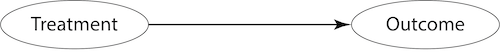

In [1]:
from IPython.display import Image
Image(filename='./images/cause examples 1.png')

Typically, to test a causal relationship (hypothesis), we would run a **Randomized Controlled Trial**.

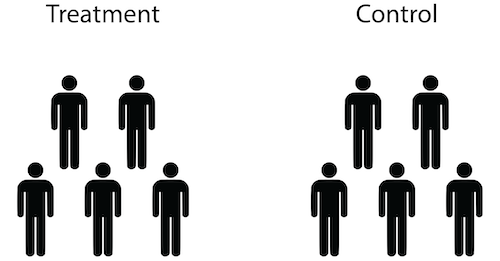

In [2]:
Image(filename='./images/RCT.png')

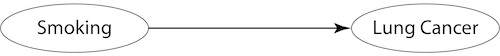

In [3]:
Image(filename='./images/cause examples 2.png')

But some experiments are costly, infeasible, and unethical.

Causal inference is a powerful statistical approach that uses **observational data** to estimate causal effects.

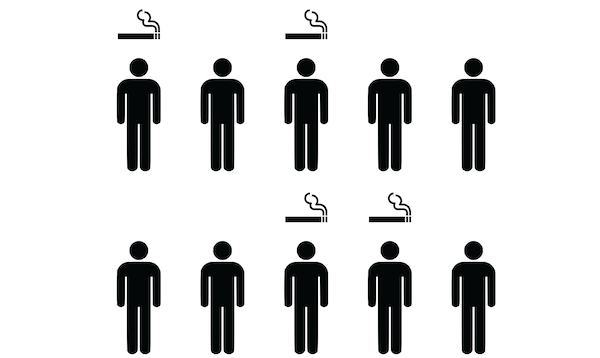

In [4]:
Image(filename='./images/observational.png')

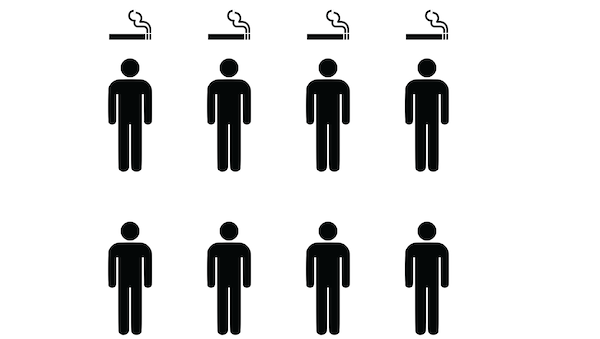

In [5]:
Image(filename='./images/Matching.png')

However, there may be confounders.

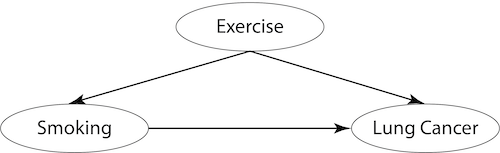

In [6]:
Image(filename='./images/cause examples 3.png')

Causal inference is hard and requires collaboration.

In [7]:
import json
import pandas as pd

### Load Data

In [8]:
data = pd.read_csv('./data/student-mat.csv', delimiter=';')
data.head(5)

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

In [9]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

address famsize Pstatus  Medu  Fedu  traveltime  studytime  failures  \
0       U     GT3       A     4     4           2          2         0   
1       U     GT3       T     1     1           1          2         0   
2       U     LE3       T     1     1           1          2         3   
3       U     GT3       T     4     2           1          3         0   
4       U     GT3       T     3     3           1          2         0   

  schoolsup famsup  ... famrel freetime goout Dalc Walc health  absences  G1  \
0       yes     no  ...      4        3     4    1    1      3         6   5   
1        no    yes  ...      5        3     3    1    1      3         4   5   
2       yes     no  ...      4        3     2    2    3      3        10   7   
3        no    yes  ...      3        2     2    1    1      5         2  15   
4        no    yes  ...      4        3     2    1    2      5         4   6   

   G2  G3  
0   6   6  
1   5   6  
2   8  10  
3  14  15  
4  10  10  

[5 rows x 26 columns]

### Constructing the DAG

In [10]:
import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

address  famsize  Pstatus  Medu  Fedu  traveltime  studytime  failures  \
0        1        0        0     4     4           2          2         0   
1        1        0        1     1     1           1          2         0   
2        1        1        1     1     1           1          2         3   
3        1        0        1     4     2           1          3         0   
4        1        0        1     3     3           1          2         0   

   schoolsup  famsup  ...  famrel  freetime  goout  Dalc  Walc  health  \
0          1       0  ...       4         3      4     1     1       3   
1          0       1  ...       5         3      3     1     1       3   
2          1       0  ...       4         3      2     2     3       3   
3          0       1  ...       3         2      2     1     1       5   
4          0       1  ...       4         3      2     1     2       5   

   absences  G1  G2  G3  
0         6   5   6   6  
1         4   5   5   6  
2        10   7   8  10  
3         2  15  14  15  
4         4   6  10  10  

[5 rows x 26 columns]

### Editing the DAG

You can pass all the attributes in the dataset to the DAG widget and construct your own DAG.
If you would like to skip this step, you can load the example from the saved DAG file in the next cell.

In [12]:
from causalvis import DAG

DAG(data=struct_data)

DAG(component='DAG', props={'attributes': ['absences', 'activities', 'address', 'Dalc', 'failures', 'famrel', …

### Identifying control variables

Once we are satisfied with the DAG, we can set the treatment and outcome variables. In this case, we are interested in `G1` as the outcome variable, while `absences` is the treatment variable of interest. After selecting these variables, we see that other attributes in the DAG are automatically colored to reflect their relationship to the treatment and outcome.

From the downloads button, we can get a list of the `confounds` and `prognostic` factors to control for.

In [13]:
with open('./data/DAG_student_example (1).json', 'r') as d:
    graph = json.load(d)

In [14]:
dg = DAG(graph=graph)
dg

DAG(component='DAG', props={'attributes': None, 'graph': {'nodes': [{'x': 60.76065021003316, 'y': 411.32658125…

In [21]:
confounds = [c['name'] for c in dg.confounds]
confounds

['Pstatus', 'failures', 'internet', 'health', 'famsup', 'Medu']

In [22]:
prognostics = [p['name'] for p in dg.prognostics]
prognostics

['studytime', 'schoolsup', 'paid', 'higher']

# Cohort Construction and Refinement

In [23]:
from causalvis import CohortEvaluator

In [24]:
data.shape

(395, 26)

In [25]:
a = data["absences"]
a = a >= a.median()
a = a.astype(int)

In [26]:
y = data["G1"]

In [27]:
covariates = confounds + prognostics

X = data[covariates]
X.dtypes

Pstatus      object
failures      int64
internet     object
health        int64
famsup       object
Medu          int64
studytime     int64
schoolsup    object
paid         object
higher       object
dtype: object

In [28]:
X = data.loc[:, covariates]
X = pd.get_dummies(X, drop_first=True)
X.shape

(395, 10)

In [29]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
ipw = IPW(lr)

/Users/grace/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/grace/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [30]:
ipw.fit(X, a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

In [31]:
propMatrix = ipw.compute_propensity_matrix(X, a).to_dict(orient="records")

In [32]:
def formatData(X, a, y, propMatrix):
    unadjustedData = []

    confounds = X.to_dict(orient="records")
    a.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    for i in range(len(confounds)):
        newDataInstance = confounds[i]
        newDataInstance['treatment'] = a[i]
        newDataInstance['propensity'] = propMatrix[i]

        unadjustedData.append(newDataInstance)
        
    return unadjustedData

# IPW

In [33]:
ceval = CohortEvaluator(unadjustedCohort=formatData(X, a, y, propMatrix))
ceval

CohortEvaluator(component='CohortEvaluator', props={'unadjustedCohort': [{'failures': 0, 'health': 3, 'Medu': …

Since the population is well balanced, we can go ahead and estimate the treatment effect. This can be done quite easily in causallib, using the `estimate_population_outcome` function. From the result, we can see that having < 4 absences a year causes a slightly higher score for `G1`.

In [34]:
len(ceval.selection["confounds"])

KeyError: 'confounds'

In [ ]:
ipw.estimate_population_outcome(X, a, y)

# Matching

In [35]:
from causallib.estimation import IPW, Matching
from causallib.preprocessing.transformers import PropensityTransformer
from causallib.preprocessing.transformers import MatchingTransformer
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [36]:
matcher = MatchingTransformer(with_replacement=True, n_neighbors=1, caliper=2)
matcher.fit(X, a, y)
Xm, am, ym = matcher.transform(X, a, y)

Xm.reset_index(drop=True, inplace=True)
am.reset_index(drop=True, inplace=True)
ym.reset_index(drop=True, inplace=True)

def learner(): return LogisticRegression(solver="liblinear",
                                         max_iter=5000,
                                         class_weight="balanced")

ipw = IPW(learner=learner())
ipw.fit(Xm, am)
propMatrixm = ipw.compute_propensity_matrix(Xm, am).to_dict(orient="records")

In [37]:
Xm.shape

(328, 10)

In [38]:
from causalvis import CohortEvaluator

ceval = CohortEvaluator(adjustedCohort=formatData(Xm, am, ym, propMatrixm), unadjustedCohort=formatData(X, a, y, propMatrix))
ceval

CohortEvaluator(component='CohortEvaluator', props={'unadjustedCohort': [{'failures': 0, 'health': 3, 'Medu': …

In [39]:
matcher = MatchingTransformer(with_replacement=True, n_neighbors=1, caliper=1)
matcher.fit(X, a, y)
Xm2, am2, ym2 = matcher.transform(X, a, y)

Xm2.reset_index(drop=True, inplace=True)
am2.reset_index(drop=True, inplace=True)
ym2.reset_index(drop=True, inplace=True)

def learner(): return LogisticRegression(solver="liblinear",
                                         max_iter=5000,
                                         class_weight="balanced")

ipw = IPW(learner=learner())
ipw.fit(Xm2, am2)
propMatrixm2 = ipw.compute_propensity_matrix(Xm2, am2).to_dict(orient="records")

In [40]:
Xm2.shape

(200, 10)

In [41]:
ceval2 = CohortEvaluator(adjustedCohort=formatData(Xm2, am2, ym2, propMatrixm2), unadjustedCohort=formatData(X, a, y, propMatrix))
ceval2

CohortEvaluator(component='CohortEvaluator', props={'unadjustedCohort': [{'failures': 0, 'health': 3, 'Medu': …

In [42]:
propensity_transform = PropensityTransformer(
    include_covariates=False, learner=learner())
matcher = Matching(propensity_transform=propensity_transform,
                   with_replacement=True, n_neighbors=1, knn_backend="sklearn")
matcher.fit(Xm2, am2, ym2)
matches = matcher._execute_matching(Xm2, am2)

In [43]:
matcher.estimate_population_outcome(Xm2, am2)

0    11.140
1    11.565
dtype: float64

In [44]:
population_outcome = matcher.estimate_population_outcome(Xm2, am2)
ATE = population_outcome[1] - population_outcome[0]
ATE

0.42499999999999893

In [45]:
ind_outcomes = matcher.estimate_individual_outcome(Xm2, am2).to_dict(orient="records")

ind_effects = []

for i in ind_outcomes:
    i_treatment = i[1]
    i_control = i[0]
    
    effect = i_treatment - i_control
    
    ind_effects.append(effect)

In [46]:
data = []
Xm_dict = Xm2.to_dict(orient="records")

for i in range(len(Xm_dict)):
    newDataInstance = Xm_dict[i]
    newDataInstance['treatment'] = int(am2[i])
    newDataInstance['outcome'] = int(ym2[i])
    newDataInstance['effect'] = int(ind_effects[i])
    data.append(newDataInstance)

In [47]:
from causalvis import TreatmentEffectExplorer

TreatmentEffectExplorer(data=data)

TreatmentEffectExplorer(component='TreatmentEffectExplorer', props={'data': [{'failures': 0, 'health': 3, 'Med…

### Why Causal Inference? Why Causalvis?

- Estimate causal effects
- Understand something about the world
- Guide decision making
- Explain predictions
- Data storytelling and journalism

### Thank you!

In [42]:
from causalvis import VersionHistory

vh = VersionHistory()
vh

VersionHistory(component='VersionHistory', props={'versions': [], 'effect': 'effect'})

In [123]:
vh.addVersion((dg.DAG, Xm2, ATE.tolist()))

In [124]:
vh.saveVersions()